In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set Seaborn plot style
sns.set_style('darkgrid')
sns.set_palette('Set2')

In [35]:
# 1. Load the data and perform quality checks
print("Step 1: Data Quality Checks")
# Load the dataset (assuming the file is in the working directory)
df = pd.read_csv('hr_comma_sep.csv')

print("Dataset shape:", df.shape)
print("\nDataset info:")
print(df.info())

print("\nChecking for missing values:")
print(df.isnull().sum())

print("\nDescriptive statistics:")
print(df.describe())

Step 1: Data Quality Checks
Dataset shape: (14999, 10)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None

Checking for missing values:
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hour



Step 2: Understanding Factors Contributing to Employee Turnover


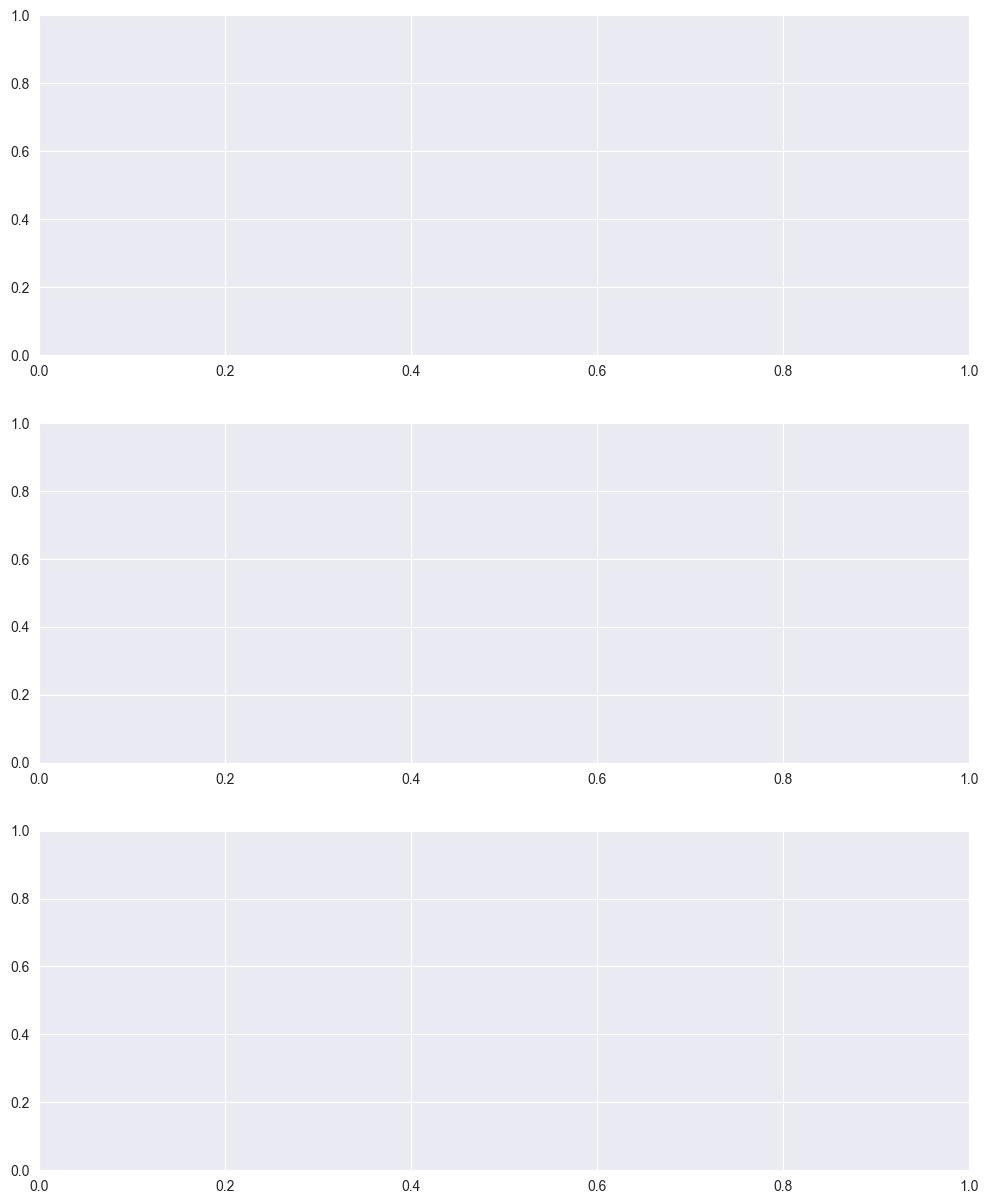

In [36]:
# 2. EDA to understand factors contributing to employee turnover
print("\n\nStep 2: Understanding Factors Contributing to Employee Turnover")

# 2.1 Correlation Heatmap
plt.figure(figsize=(12, 10))
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=15)
plt.savefig('correlation_heatmap.png')
plt.close()

# 2.2 Distribution plots
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

In [37]:
# Employee Satisfaction
sns.histplot(data=df, x='satisfaction_level', hue='left', kde=True, ax=axes[0])
axes[0].set_title('Distribution of Employee Satisfaction', fontsize=12)
axes[0].set_xlabel('Satisfaction Level')

# Employee Evaluation
sns.histplot(data=df, x='last_evaluation', hue='left', kde=True, ax=axes[1])
axes[1].set_title('Distribution of Employee Evaluation', fontsize=12)
axes[1].set_xlabel('Evaluation Score')

# Employee Average Monthly Hours
sns.histplot(data=df, x='average_montly_hours', hue='left', kde=True, ax=axes[2])
axes[2].set_title('Distribution of Average Monthly Hours', fontsize=12)
axes[2].set_xlabel('Average Monthly Hours')

plt.tight_layout()
plt.savefig('distribution_plots.png')
plt.close()

# 2.3 Bar plot of project count
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='number_project', hue='left')
plt.title('Employee Project Count by Turnover Status', fontsize=15)
plt.xlabel('Number of Projects')
plt.ylabel('Count')
plt.savefig('project_count.png')
plt.close()

print("EDA plots generated and saved.")
print("Inferences from project count plot: Employees with either too few (2-3) or too many (6-7) projects have higher turnover rates.")



EDA plots generated and saved.
Inferences from project count plot: Employees with either too few (2-3) or too many (6-7) projects have higher turnover rates.


In [38]:

# 3. Clustering of employees who left
print("\n\nStep 3: Clustering of Employees Who Left")

# 3.1 Filter employees who left and select relevant columns
left_emp = df[df['left'] == 1][['satisfaction_level', 'last_evaluation']]

# 3.2 K-means clustering with 3 clusters
# Scale the data for clustering
scaler = StandardScaler()
left_emp_scaled = scaler.fit_transform(left_emp)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
left_emp['cluster'] = kmeans.fit_predict(left_emp_scaled)





Step 3: Clustering of Employees Who Left


In [39]:

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=left_emp, x='satisfaction_level', y='last_evaluation', hue='cluster', palette='viridis', s=100)
plt.title('K-means Clustering of Employees Who Left', fontsize=15)
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')

# Plot cluster centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5, marker='X')
plt.savefig('employee_clusters.png')
plt.close()

print("Employee clustering completed and visualization saved.")
print("Thoughts on employee clusters:")
print("Cluster 0: High performers but low satisfaction (likely overworked or underappreciated)")
print("Cluster 1: Low performers with low satisfaction (disengaged employees)")
print("Cluster 2: High performers with medium-high satisfaction (possibly left for better opportunities)")



Employee clustering completed and visualization saved.
Thoughts on employee clusters:
Cluster 0: High performers but low satisfaction (likely overworked or underappreciated)
Cluster 1: Low performers with low satisfaction (disengaged employees)
Cluster 2: High performers with medium-high satisfaction (possibly left for better opportunities)


In [40]:
# 4. Handle Class Imbalance using SMOTE
print("\n\nStep 4: Handling Class Imbalance")

# 4.1 Pre-process data by converting categorical columns to numerical
# Separate categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Apply get_dummies to categorical columns
df_cat = pd.get_dummies(df[categorical_cols], drop_first=True)
df_num = df[numerical_cols]

# Combine categorical and numerical columns
df_processed = pd.concat([df_num, df_cat], axis=1)

print("Shape after preprocessing:", df_processed.shape)
print("Columns after preprocessing:", df_processed.columns.tolist())

# 4.2 Split data into training and testing sets with stratification
X = df_processed.drop('left', axis=1)
y = df_processed['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")
print(f"Class distribution before SMOTE - Train: {y_train.value_counts()}")

# 4.3 Apply SMOTE to upsample the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Class distribution after SMOTE - Train: {pd.Series(y_train_smote).value_counts()}")



Step 4: Handling Class Imbalance
Shape after preprocessing: (14999, 19)
Columns after preprocessing: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years', 'sales_RandD', 'sales_accounting', 'sales_hr', 'sales_management', 'sales_marketing', 'sales_product_mng', 'sales_sales', 'sales_support', 'sales_technical', 'salary_low', 'salary_medium']
Training set shape: (11999, 18), Testing set shape: (3000, 18)
Class distribution before SMOTE - Train: left
0    9142
1    2857
Name: count, dtype: int64
Class distribution after SMOTE - Train: left
0    9142
1    9142
Name: count, dtype: int64


In [41]:
# 5. Perform 5-fold cross-validation model training and evaluate performance
print("\n\nStep 5: Model Training with 5-fold Cross-Validation")

# Define 5-fold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5.1 Logistic Regression
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_smote, y_train_smote)
lr_scores = cross_val_score(lr_model, X_train_smote, y_train_smote, cv=cv, scoring='f1')
print(f"Logistic Regression CV F1 Scores: {lr_scores}")
print(f"Mean CV F1 Score: {lr_scores.mean():.4f}")

# Predict on test set
lr_preds = lr_model.predict(X_test)
print("Logistic Regression Classification Report:")
lr_report = classification_report(y_test, lr_preds)
print(lr_report)

# 5.2 Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)
rf_scores = cross_val_score(rf_model, X_train_smote, y_train_smote, cv=cv, scoring='f1')
print(f"Random Forest CV F1 Scores: {rf_scores}")
print(f"Mean CV F1 Score: {rf_scores.mean():.4f}")

# Predict on test set
rf_preds = rf_model.predict(X_test)
print("Random Forest Classification Report:")
rf_report = classification_report(y_test, rf_preds)
print(rf_report)

# 5.3 Gradient Boosting
print("\nTraining Gradient Boosting...")
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_smote, y_train_smote)
gb_scores = cross_val_score(gb_model, X_train_smote, y_train_smote, cv=cv, scoring='f1')
print(f"Gradient Boosting CV F1 Scores: {gb_scores}")
print(f"Mean CV F1 Score: {gb_scores.mean():.4f}")

# Predict on test set
gb_preds = gb_model.predict(X_test)
print("Gradient Boosting Classification Report:")
gb_report = classification_report(y_test, gb_preds)
print(gb_report)




Step 5: Model Training with 5-fold Cross-Validation

Training Logistic Regression...
Logistic Regression CV F1 Scores: [0.79234973 0.81015973 0.79431483 0.80245268 0.79723257]
Mean CV F1 Score: 0.7993
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.84      2286
           1       0.51      0.74      0.60       714

    accuracy                           0.77      3000
   macro avg       0.71      0.76      0.72      3000
weighted avg       0.81      0.77      0.78      3000


Training Random Forest...
Random Forest CV F1 Scores: [0.9845047  0.98312586 0.98506637 0.98315382 0.98508287]
Mean CV F1 Score: 0.9842
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.97      0.98      0.97       714

    accuracy                           0.99      3000
   macro avg       0.98      0.98  

In [42]:
# 6. Identify the best model and justify evaluation metrics
print("\n\nStep 6: Model Evaluation and Comparison")

# 6.1 Find ROC/AUC for each model and plot ROC curve
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison', fontsize=15)
plt.legend(loc='best')
plt.savefig('roc_curve.png')
plt.close()

# 6.2 Confusion Matrix for each model
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}', fontsize=15)
    plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
    plt.close()
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\n{model_name} Confusion Matrix:")
    print(f"True Negatives: {tn}, False Positives: {fp}")
    print(f"False Negatives: {fn}, True Positives: {tp}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    return precision, recall

lr_precision, lr_recall = plot_confusion_matrix(y_test, lr_preds, 'Logistic Regression')
rf_precision, rf_recall = plot_confusion_matrix(y_test, rf_preds, 'Random Forest')
gb_precision, gb_recall = plot_confusion_matrix(y_test, gb_preds, 'Gradient Boosting')

# 6.3 Explanation of which metric to use (Recall or Precision)
print("\nMetric Justification:")
print("For employee turnover prediction, Recall is more important than Precision because:")
print("- High Recall ensures we identify most employees who are likely to leave (minimizing False Negatives)")
print("- Missing an employee who's likely to leave (False Negative) is more costly than incorrectly")
print("  identifying an employee as likely to leave (False Positive)")
print("- Resources can be allocated to retain high-value employees who might otherwise leave unnoticed")

# Determine best model based on recall
models_recall = {
    'Logistic Regression': lr_recall,
    'Random Forest': rf_recall,
    'Gradient Boosting': gb_recall
}

best_model_name = max(models_recall, key=models_recall.get)
print(f"\nBest model based on Recall: {best_model_name} with Recall of {models_recall[best_model_name]:.4f}")

# Select the best model for further analysis
if best_model_name == 'Logistic Regression':
    best_model = lr_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
else:
    best_model = gb_model





Step 6: Model Evaluation and Comparison

Logistic Regression Confusion Matrix:
True Negatives: 1771, False Positives: 515
False Negatives: 184, True Positives: 530
Precision: 0.5072, Recall: 0.7423

Random Forest Confusion Matrix:
True Negatives: 2266, False Positives: 20
False Negatives: 16, True Positives: 698
Precision: 0.9721, Recall: 0.9776

Gradient Boosting Confusion Matrix:
True Negatives: 2231, False Positives: 55
False Negatives: 45, True Positives: 669
Precision: 0.9240, Recall: 0.9370

Metric Justification:
For employee turnover prediction, Recall is more important than Precision because:
- High Recall ensures we identify most employees who are likely to leave (minimizing False Negatives)
- Missing an employee who's likely to leave (False Negative) is more costly than incorrectly
  identifying an employee as likely to leave (False Positive)
- Resources can be allocated to retain high-value employees who might otherwise leave unnoticed

Best model based on Recall: Random F

In [43]:
# 7. Retention strategies for targeted employees
print("\n\nStep 7: Retention Strategies for Targeted Employees")

# 7.1 Predict probability of employee turnover in test data
turnover_prob = best_model.predict_proba(X_test)[:, 1]

# Create a dataframe with employee IDs and their turnover probabilities
employee_risk = pd.DataFrame({
    'Employee_ID': X_test.index,
    'Turnover_Probability': turnover_prob
})

# 7.2 Categorize employees into risk zones
def categorize_risk(probability):
    if probability < 0.2:
        return 'Safe Zone (Green)'
    elif probability < 0.6:
        return 'Low-Risk Zone (Yellow)'
    elif probability < 0.9:
        return 'Medium-Risk Zone (Orange)'
    else:
        return 'High-Risk Zone (Red)'

employee_risk['Risk_Zone'] = employee_risk['Turnover_Probability'].apply(categorize_risk)

# Count employees in each risk zone
risk_zone_counts = employee_risk['Risk_Zone'].value_counts()
print("Number of employees in each risk zone:")
print(risk_zone_counts)

# Visualize risk zones
plt.figure(figsize=(10, 6))
sns.countplot(x='Risk_Zone', data=employee_risk, order=[
    'Safe Zone (Green)', 
    'Low-Risk Zone (Yellow)', 
    'Medium-Risk Zone (Orange)', 
    'High-Risk Zone (Red)'
])
plt.title('Employee Distribution by Risk Zone', fontsize=15)
plt.xlabel('Risk Zone')
plt.ylabel('Number of Employees')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('risk_zones.png')
plt.close()





Step 7: Retention Strategies for Targeted Employees
Number of employees in each risk zone:
Risk_Zone
Safe Zone (Green)            2183
High-Risk Zone (Red)          660
Low-Risk Zone (Yellow)        112
Medium-Risk Zone (Orange)      45
Name: count, dtype: int64


In [44]:
# Save the employee risk dataframe to CSV
employee_risk.to_csv('employee_risk_assessment.csv', index=False)

print("\nRetention strategies for each zone:")
print("\n1. Safe Zone (Green) - Score < 20%:")
print("   - Regular check-ins to maintain satisfaction")
print("   - Growth opportunities and skill development")
print("   - Recognition for good performance")
print("   - Use these employees as mentors for new hires")

print("\n2. Low-Risk Zone (Yellow) - 20% < Score < 60%:")
print("   - More frequent manager check-ins")
print("   - Career development discussions")
print("   - Address workload concerns")
print("   - Consider salary reviews or non-monetary benefits")
print("   - Training opportunities")

print("\n3. Medium-Risk Zone (Orange) - 60% < Score < 90%:")
print("   - Urgent one-on-one meetings to understand concerns")
print("   - Targeted interventions based on individual factors")
print("   - Consider role changes, team transfers or flexible work arrangements")
print("   - Competitive compensation review")
print("   - Recognition programs")

print("\n4. High-Risk Zone (Red) - Score > 90%:")
print("   - Immediate intervention by management and HR")
print("   - Personalized retention plan with clear milestones")
print("   - Consider urgent promotions or salary increases if warranted")
print("   - Implement immediate workload adjustments")
print("   - Assess reasons for likely departure and address root causes")
print("   - Prepare succession planning in case retention efforts fail")

print("\n\nAnalysis complete. All outputs have been saved.")




Retention strategies for each zone:

1. Safe Zone (Green) - Score < 20%:
   - Regular check-ins to maintain satisfaction
   - Growth opportunities and skill development
   - Recognition for good performance
   - Use these employees as mentors for new hires

2. Low-Risk Zone (Yellow) - 20% < Score < 60%:
   - More frequent manager check-ins
   - Career development discussions
   - Address workload concerns
   - Consider salary reviews or non-monetary benefits
   - Training opportunities

3. Medium-Risk Zone (Orange) - 60% < Score < 90%:
   - Urgent one-on-one meetings to understand concerns
   - Targeted interventions based on individual factors
   - Consider role changes, team transfers or flexible work arrangements
   - Competitive compensation review
   - Recognition programs

4. High-Risk Zone (Red) - Score > 90%:
   - Immediate intervention by management and HR
   - Personalized retention plan with clear milestones
   - Consider urgent promotions or salary increases if warranted
 

In [45]:
# Feature importance for the best model (if Random Forest or Gradient Boosting was selected)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    plt.figure(figsize=(12, 8))
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    sns.barplot(x='Importance', y='Feature', data=importances[:10])
    plt.title(f'Top 10 Feature Importances - {best_model_name}', fontsize=15)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
    
    print("\nTop factors contributing to employee turnover:")
    print(importances[:5])


Top factors contributing to employee turnover:
                Feature  Importance
0    satisfaction_level    0.268681
4    time_spend_company    0.241882
2        number_project    0.146383
3  average_montly_hours    0.146208
1       last_evaluation    0.123119
